In [1]:
import pandas as pd
import numpy as np
import math as maths
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [3]:
usecolsResult = ["eventType", "keyValue", "x", "y", "offsetX", "offsetY", "keyCenterX", "keyCenterY", "holdTime", "flightTime", "pressure"]
usecolsTarget = ["eventType",  "keyValue", "offsetX", "offsetY", "keyCenterX", "keyCenterY", "holdTime", "flightTime", "pressure"]

path = "C:/Users/mathi/OneDrive/Bachelor Stuff/Studie/Pilot/KeyStrokeLog"
path_ = "E:/OneDrive/Bachelor Stuff/Studie/Pilot/KeyStrokeLog"
targetGroupPath = path + "ID_targetValues/"

pidList = os.listdir(path)
pidList.remove("ID_targetValues")
pidList.remove("read csv.py")
pidList.remove("read csv - Kopie.py")

values = []

#One iteration = one Participant
for pid in pidList:
	# Build filepaths for all tasks for current pid
	taskGroupPath = path + pid + "/"
	taskGroupList = os.listdir(taskGroupPath)
	taskPathDict = {}
	targetPathDict = {}
	for taskGroup in taskGroupList:
		# Filter out user created tasks
		if taskGroup != "17_user-created password":
			taskDirs = [task  for task in sorted(os.listdir(taskGroupPath + taskGroup))]
			taskPathDict[taskGroup] = [(taskGroup + "/" + taskDir)  for taskDir in taskDirs if not taskDir == "17_user-created password"]
			targetPathDict[taskGroup] = [(taskGroup + "/" + taskDir)  for taskDir in taskDirs if not taskDir == "17_user-created password"]
			
	# One iteration = one taskgroup
	for key in sorted(taskPathDict.keys()):
		#One iteration = one task (3 csv files per task)
		for task in sorted(taskPathDict[key]):
			# last 3 csv files in <task> read as a list of dataframes
			taskResultList = [pd.read_csv(taskGroupPath + task + "/" + entry, sep=';', header=0, usecols=usecolsResult) for entry in [taskEntry for taskEntry in sorted(os.listdir(taskGroupPath + task), reverse=True) if taskEntry.startswith('valid')][:3]]
			# target df for that specific result
			targetDf = pd.read_csv(targetGroupPath + task + "/" + os.listdir(targetGroupPath + task)[0], sep=';', header=0, usecols=usecolsTarget)
			targetDf = targetDf.add_prefix('target_')
			# Combine resultDataframes with target DF (horizontally)
			for resultDf in taskResultList:
				resultAndTargetTempDF = pd.concat([resultDf, targetDf], axis = 1)
				resultAndTargetTempDF["task"] = task[-2:]
 				resultAndTargetTempDF["pId"] = pid
				values.append(resultAndTargetTempDF)
	print "Finished " + pid
masterDF = pd.concat(values, axis=0)
masterDF['area_error'] = masterDF.apply(lambda row: np.absolute(row['pressure'] - row['target_pressure']), axis=1)
masterDF['htime_error'] = masterDF.apply(lambda row: np.absolute(row['holdTime'] - row['target_holdTime']), axis=1)
masterDF['ftime_error'] = masterDF.apply(lambda row: np.absolute(row['flightTime'] - row['target_flightTime']), axis=1)
masterDF['offset_error'] = masterDF.apply(lambda row: maths.hypot(row['offsetX'] - row['target_offsetX'], row['offsetY'] - row['target_offsetY']), axis=1)
print "Finished concat"

Finished ID_0
Finished ID_1
Finished ID_2
Finished concat


In [4]:
# Error Dataframes
defaultAreaError = masterDF[(masterDF['eventType'] == "up") & (masterDF['target_pressure'] == 0.2)][['area_error', 'task', 'pId']]
bigAreaError = masterDF[(masterDF['eventType'] == "up") & (masterDF['target_pressure'] == 0.45)][['area_error', 'task', 'pId']]

defaultHoldTimeError = masterDF[(masterDF['target_holdTime'] == 80)][['htime_error', 'task', 'pId']]
longHoldTimeError = masterDF[(masterDF['target_holdTime'] == 300)][['htime_error', 'task', 'pId']]

defaultFlightTimeError = masterDF[(masterDF['target_flightTime'] == 260)][['ftime_error', 'task', 'pId']]
longFlightTimeError = masterDF[(masterDF['target_flightTime'] == 1000)][['ftime_error', 'task', 'pId']]

centerOffsetError = masterDF[(masterDF['target_offsetX'] == 0) & (masterDF['target_offsetY'] == 0)][['offset_error', 'task', 'pId']]
leftOffsetError = masterDF[(masterDF['target_offsetX'] == -45) & (masterDF['target_offsetY'] == 0)][['offset_error', 'task', 'pId']]
rightOffsetError = masterDF[(masterDF['target_offsetX'] == 45) & (masterDF['target_offsetY'] == 0)][['offset_error', 'task', 'pId']]
topOffsetError = masterDF[(masterDF['target_offsetX'] == 0) & (masterDF['target_offsetY'] == -80)][['offset_error', 'task', 'pId']]
bottomOffsetError = masterDF[(masterDF['target_offsetX'] == 0) & (masterDF['target_offsetY'] == 80)][['offset_error', 'task', 'pId']]

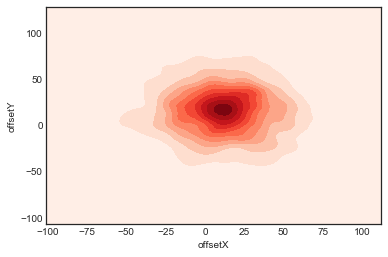

In [120]:
# Center offset contour plot
offsets = masterDF[(masterDF['target_offsetX'] == 0) & (masterDF['target_offsetY'] == 0)][["offsetX", "offsetY", 'task', 'pId']]
 
sns.kdeplot(offsets['offsetX'], offsets['offsetY'], cmap="Reds", shade=True, bw=5)

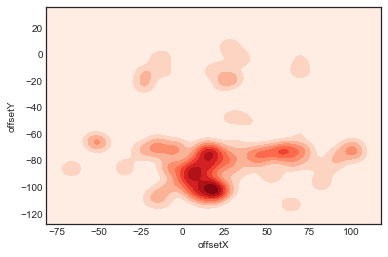

In [121]:
# Bottom offset contour plot
offsets = masterDF[(masterDF['target_offsetX'] == 0) & (masterDF['target_offsetY'] == 80)][["offsetX", "offsetY", 'task', 'pId']]
offsets['offsetY'] = offsets.apply(lambda row: row['offsetY'] * (-1), axis=1)
sns.kdeplot(offsets['offsetX'], offsets['offsetY'], cmap="Reds", shade=True, bw=5)

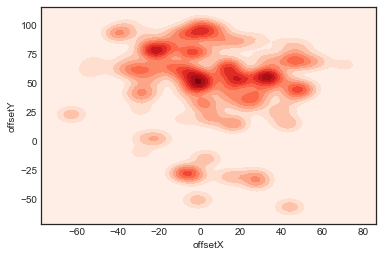

In [122]:
# Top offset contour plot
offsets = masterDF[(masterDF['target_offsetX'] == 0) & (masterDF['target_offsetY'] == -80)][["offsetX", "offsetY", 'task', 'pId']]
offsets['offsetY'] = offsets.apply(lambda row: row['offsetY'] * (-1), axis=1)
sns.kdeplot(offsets['offsetX'], offsets['offsetY'], cmap="Reds", shade=True, bw=5)

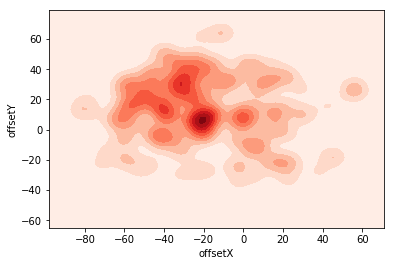

In [7]:
# Left offset contour plot
offsets = masterDF[(masterDF['target_offsetX'] == -45) & (masterDF['target_offsetY'] == 0)][["offsetX", "offsetY", 'task', 'pId']]
sns.kdeplot(offsets['offsetX'], offsets['offsetY'], cmap="Reds", shade=True, bw=5)

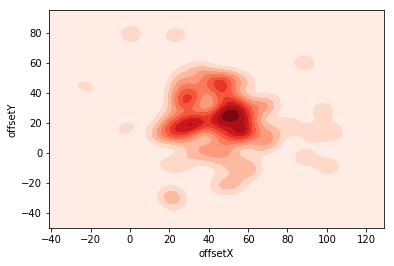

In [8]:
# Right offset contour plot
offsets = masterDF[(masterDF['target_offsetX'] == 45) & (masterDF['target_offsetY'] == 0)][["offsetX", "offsetY", 'task', 'pId']]
sns.kdeplot(offsets['offsetX'], offsets['offsetY'], cmap="Reds", shade=True, bw=5)

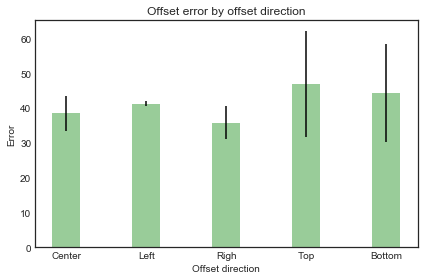

In [123]:
# Offset Error
meanCenterOffsetError = centerOffsetError['offset_error'].mean()
meanLeftOffsetError = leftOffsetError['offset_error'].mean()
meanRightOffsetError = rightOffsetError['offset_error'].mean()
meanTopOffsetError = topOffsetError['offset_error'].mean()
meanBottomOffsetError = bottomOffsetError['offset_error'].mean()

pCenterOffsetStd = centerOffsetError.groupby('pId')['offset_error'].mean().std()
pLeftOffsetStd = leftOffsetError.groupby('pId')['offset_error'].mean().std()
pRightOffsetStd = rightOffsetError.groupby('pId')['offset_error'].mean().std()
pTopOffsetStd = topOffsetError.groupby('pId')['offset_error'].mean().std()
pBottomOffsetStd = bottomOffsetError.groupby('pId')['offset_error'].mean().std()

offset_means = (meanCenterOffsetError, meanLeftOffsetError, meanRightOffsetError, meanTopOffsetError, meanBottomOffsetError)
offset_stds = (pCenterOffsetStd, pLeftOffsetStd, pRightOffsetStd, pTopOffsetStd, pBottomOffsetStd)

fig, ax = plt.subplots()

index = np.arange(len(offset_means))
bar_width = 0.35

opacity = 0.4

rects = ax.bar(index, offset_means, bar_width, 
               alpha=opacity, color='g', yerr=offset_stds)

ax.set_xlabel('Offset direction')
ax.set_ylabel('Error')
ax.set_title('Offset error by offset direction')
ax.set_xticks(index)
ax.set_xticklabels(('Center', 'Left', 'Righ', 'Top', 'Bottom'))
ax.legend()

fig.tight_layout()
plt.show()

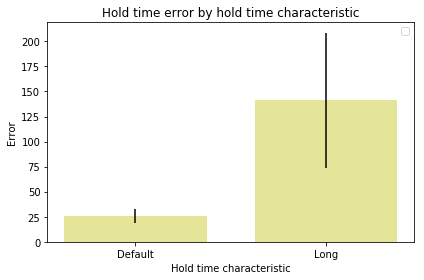

In [50]:
# Hold time Error
meanDefaultHoldTimeError = defaultHoldTimeError['htime_error'].mean()
meanLongHoldTimeError = longHoldTimeError['htime_error'].mean()

pDefaultHoldTimeErrorStd = defaultHoldTimeError.groupby('pId')['htime_error'].mean().std()
pLongHoldTimeErrorStd = longHoldTimeError.groupby('pId')['htime_error'].mean().std()

holdtime_means = (meanDefaultHoldTimeError, meanLongHoldTimeError)
holdtime_stds = (pDefaultHoldTimeErrorStd, pLongHoldTimeErrorStd)

fig, ax = plt.subplots()

index = np.arange(len(area_means))
bar_width = 0.75

opacity = 0.4

rects = ax.bar(index, holdtime_means, bar_width, 
               alpha=opacity, color='y', yerr=holdtime_stds)

ax.set_xlabel('Hold time characteristic')
ax.set_ylabel('Error')
ax.set_title('Hold time error by hold time characteristic')
ax.set_xticks(index)
ax.set_xticklabels(('Default', 'Long'))
ax.legend()

fig.tight_layout()
plt.show()

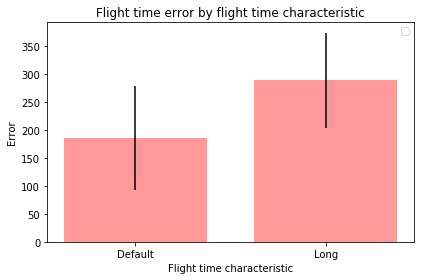

In [53]:
# Flight time Error
meanDefaultFlightTimeError = defaultFlightTimeError['ftime_error'].mean()
meanLongFlightTimeError = longFlightTimeError['ftime_error'].mean()

pDefaultFlightTimeErrorStd = defaultFlightTimeError.groupby('pId')['ftime_error'].mean().std()
pLongFlightTimeErrorStd = longFlightTimeError.groupby('pId')['ftime_error'].mean().std()

flighttime_means = (meanDefaultFlightTimeError, meanLongFlightTimeError)
flighttime_stds = (pDefaultFlightTimeErrorStd, pLongFlightTimeErrorStd)

fig, ax = plt.subplots()

index = np.arange(len(area_means))
bar_width = 0.75

opacity = 0.4

rects = ax.bar(index, flighttime_means, bar_width, 
               alpha=opacity, color='r', yerr=flighttime_stds)

ax.set_xlabel('Flight time characteristic')
ax.set_ylabel('Error')
ax.set_title('Flight time error by flight time characteristic')
ax.set_xticks(index)
ax.set_xticklabels(('Default', 'Long'))
ax.legend()

fig.tight_layout()
plt.show()

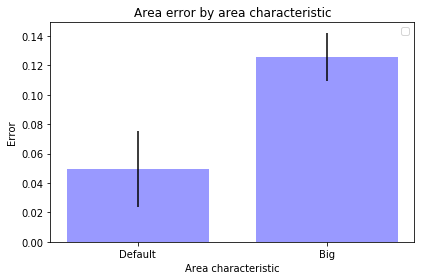

In [51]:
# Area Error
meanDefaultAreaError = defaultAreaError['area_error'].mean()
meanBigAreaError = bigAreaError['area_error'].mean()

pDefaultAreaErrorStd = defaultAreaError.groupby('pId')['area_error'].mean().std()
pBigAreaErrorStd = bigAreaError.groupby('pId')['area_error'].mean().std()

area_means = (meanDefaultAreaError, meanBigAreaError)
area_stds = (pDefaultAreaErrorStd, pBigAreaErrorStd)

fig, ax = plt.subplots()

index = np.arange(len(area_means))
bar_width = 0.75

opacity = 0.4

rects = ax.bar(index, area_means, bar_width, 
               alpha=opacity, color='b', yerr=area_stds)

ax.set_xlabel('Area characteristic')
ax.set_ylabel('Error')
ax.set_title('Area error by area characteristic')
ax.set_xticks(index)
ax.set_xticklabels(('Default', 'Big'))
ax.legend()

fig.tight_layout()
plt.show()